In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<h2> Load Image </h2>

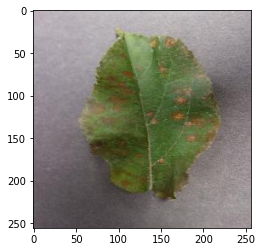

In [206]:
imageNo = 3

imagePath = f'../../rust/apple_cedar_apple_rust/{imageNo}.jpg'

image = cv2.cvtColor(cv2.imread(imagePath), cv2.COLOR_BGR2RGB)

plt.imshow(image)

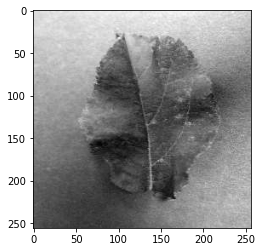

In [207]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), cmap = 'gray')

In [208]:
#contrats stretching
def stretch_contrast(image:np.ndarray) -> np.ndarray:
    '''
    Function to perform contrast stretching given an input image.
    
    Inputs =>
    image : numpy.ndarray representation of the image (must be only one channel)
    
    Returns =>
    con_image : min-max contrast stretched representation of the input image
    
    '''
    
    con_image = np.copy(image).reshape(-1)
    
    #min intensity
    min_i = np.amin(con_image)
    #max intensity
    max_i = np.amax(con_image)
    
    for idx, pixel in enumerate(con_image):
        
        con_image[idx] = 255 * ((pixel - min_i) / (max_i - min_i))
    
    #reshape and return
    con_image = con_image.reshape(image.shape)
    con_image = con_image.astype("uint8")
    
    return con_image



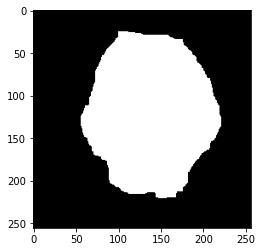

In [209]:
def extract_background(image):
    '''
    Perform k-means channel segmentation on the input mildew affected leaf.
    
    Inputs:
    image=> np.ndarray representation of the image. Background must be segmented
    mask=> mask for the leaf region on the image.
    
    returns:
    segment => segmentation result 
    '''
    im = image.copy()
    #convert to lab
    lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

    #create a vector containing a*b* channel
    shape = lab.shape
    vector = lab[:, :, 1:]
    vector = vector.reshape(-1, 2)

    #convert to float32
    vector = np.float32(vector)

    #apply kmeans algorithm
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    K=3
    attempts=20
    _,label,center=cv2.kmeans(vector, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    #get centroids
    center = np.uint8(center)
    res = center[label.flatten()]

    resArr = []
    #convert into an image with constant luminance
    for ele in res:
        a,b = ele[0], ele[1]
        resArr.append([90, a, b])
        
    resArr = np.array(resArr, dtype = np.uint8).reshape(shape)

    #segment automatically based on min a* value
    a_channel = resArr[:,:,1]
    
    maxVal = np.amax(a_channel)

    resImg = []

    #loop and apply thresholding
    for ele1 in resArr.reshape(-1,3):

        a = ele1[1]

        if a == maxVal:
            resImg.append([0])

        else:
            resImg.append([255])
            

    resImg = np.array(resImg, dtype = np.uint8).reshape(image.shape[:2])
    opening = cv2.morphologyEx(resImg, cv2.MORPH_OPEN, kernel = np.ones((5, 5)), iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel = np.ones((5, 5)), iterations = 2)
    cnts, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill contour for mask
    mask = np.ones(im.shape[:2], dtype="uint8") * 0
    mask = cv2.drawContours(mask, cnts, -1, (255), cv2.FILLED)
    return mask

mask = extract_background(image)

plt.imshow(mask, cmap = 'gray')

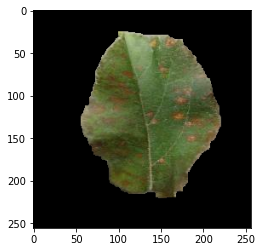

In [210]:
leaf = cv2.bitwise_and(image, image, mask = mask)
plt.imshow(leaf)


<h2> Convert to HSV</h2>

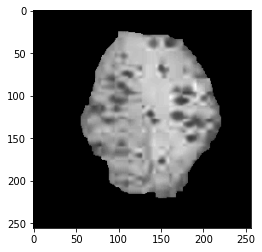

In [224]:
hsv = cv2.cvtColor(leaf, cv2.COLOR_RGB2HSV)
h = hsv[:, :, 0]
h = stretch_contrast(h)
plt.imshow(h, cmap = 'gray')

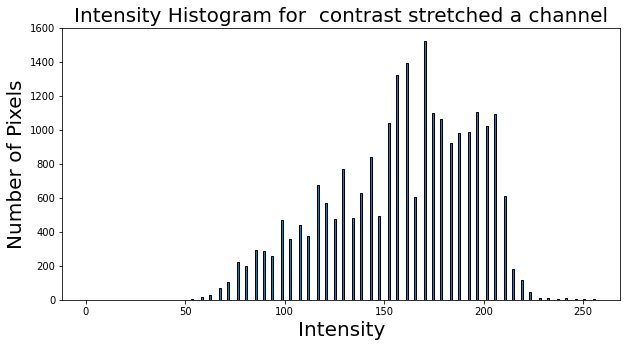

In [225]:
plt.figure(figsize = (10, 5))
plt.title("Intensity Histogram for  contrast stretched a channel", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_= plt.hist(h.flat, bins=255, range=(1, 256),ec='black')
plt.show()

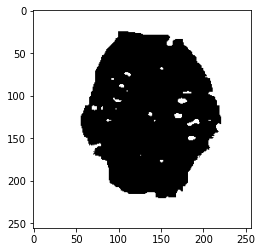

In [226]:
_, th = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
th = 255 - th
plt.imshow(th, cmap = 'gray')

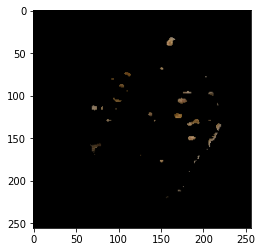

In [227]:
res = cv2.bitwise_and(leaf, leaf, mask = th)
plt.imshow(res)

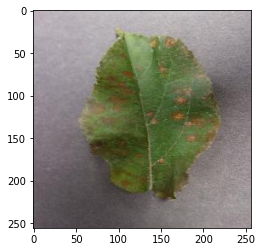

In [228]:
plt.imshow(image)